In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# set random seed
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

#print(os.listdir("../input"))
print(os.listdir('/kaggle/input/'))

['skin-cancer-mnist-ham10000']


In [2]:
data_dir = '../input/skin-cancer-mnist-ham10000'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
def compute_img_mean_std(image_paths):

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [4]:
# Values stored to save future run time
norm_mean = [0.7630392, 0.5456477, 0.57004845]
norm_std = [0.1409286, 0.15261266, 0.16997074]

In [5]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [6]:
# Determine how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# Filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [7]:
# Identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# Create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# Apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,duplicated


In [8]:
# Filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [9]:
# Create a val set using df as none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [10]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identify train and val rows
# Create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# Apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# Filter out training rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [11]:
df_train['cell_type'].value_counts()

cell_type
Melanocytic nevi                  5822
dermatofibroma                    1067
Benign keratosis-like lesions     1011
Basal cell carcinoma               479
Actinic keratoses                  297
Vascular lesions                   129
Dermatofibroma                     107
Name: count, dtype: int64

In [12]:
# Split the test set again in a validation set and a true test set:
df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [13]:
print(len(df_test))
df_test['cell_type'].value_counts()

552


cell_type
Melanocytic nevi                  444
Benign keratosis-like lesions      47
dermatofibroma                     20
Basal cell carcinoma               15
Actinic keratoses                  12
Vascular lesions                    8
Dermatofibroma                      6
Name: count, dtype: int64

In [14]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [15]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "mobilenet":
        model_ft = models.mobilenet_v2(pretrained=True, progress=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    else:
        print("Invalid model name")
        exit()

    return model_ft, input_size

In [16]:
print(torch.cuda.is_available())

True


In [17]:
model_name = "mobilenet"
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Using device: cuda')
else:
    print("Using device: cpu")
model = model_ft.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 93.0MB/s]


Using device: cuda


In [18]:
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), 
                                      transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the test images.
test_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                     transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [19]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [20]:
# Define the training set using the table train_df and using the defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

# Same for the test set:
test_set = HAM10000(df_test, transform=train_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

In [21]:
# Set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [22]:
# This function is used during training process, to calculate the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1

    print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
        epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
    total_loss_train.append(train_loss.avg)
    total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [24]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader)):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [36]:
epoch_num = 10 
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in tqdm(range(1, epoch_num+1)):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))

  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 1], [iter 279 / 279], [train loss 0.62303], [train acc 0.77677]



0it [00:00, ?it/s]
1it [00:00,  1.26it/s]
4it [00:00,  5.31it/s]
6it [00:01,  4.19it/s]
9it [00:02,  3.91it/s]
12it [00:02,  5.91it/s]
14it [00:03,  4.66it/s]
18it [00:03,  4.88it/s]
 10%|█         | 1/10 [01:00<09:08, 60.99s/it]

------------------------------------------------------------
[epoch 1], [val loss 0.34121], [val acc 0.87847]
------------------------------------------------------------
best record: [epoch 1], [val loss 0.34121], [val acc 0.87847]
[epoch 2], [iter 279 / 279], [train loss 0.59723], [train acc 0.78125]



0it [00:00, ?it/s]
1it [00:00,  1.28it/s]
4it [00:00,  5.49it/s]
6it [00:01,  4.27it/s]
8it [00:01,  5.98it/s]
10it [00:02,  4.16it/s]
13it [00:03,  4.22it/s]
16it [00:03,  6.21it/s]
18it [00:03,  4.99it/s]
 20%|██        | 2/10 [02:01<08:03, 60.45s/it]

------------------------------------------------------------
[epoch 2], [val loss 0.32909], [val acc 0.89583]
------------------------------------------------------------
best record: [epoch 2], [val loss 0.32909], [val acc 0.89583]
[epoch 3], [iter 279 / 279], [train loss 0.58403], [train acc 0.78707]



0it [00:00, ?it/s]
1it [00:00,  1.29it/s]
4it [00:00,  5.59it/s]
6it [00:01,  3.89it/s]
9it [00:02,  3.96it/s]
12it [00:02,  6.07it/s]
14it [00:03,  4.81it/s]
18it [00:03,  4.97it/s]
 30%|███       | 3/10 [03:01<07:03, 60.44s/it]

------------------------------------------------------------
[epoch 3], [val loss 0.31853], [val acc 0.89583]
------------------------------------------------------------
[epoch 4], [iter 279 / 279], [train loss 0.56310], [train acc 0.79245]



0it [00:00, ?it/s]
1it [00:00,  1.28it/s]
3it [00:00,  3.93it/s]
5it [00:01,  3.42it/s]
7it [00:01,  5.26it/s]
9it [00:02,  4.23it/s]
12it [00:02,  6.66it/s]
14it [00:03,  4.90it/s]
18it [00:03,  4.96it/s]
 40%|████      | 4/10 [04:02<06:02, 60.50s/it]

------------------------------------------------------------
[epoch 4], [val loss 0.29773], [val acc 0.89583]
------------------------------------------------------------
[epoch 5], [iter 279 / 279], [train loss 0.54441], [train acc 0.79917]



0it [00:00, ?it/s]
1it [00:00,  1.16it/s]
3it [00:00,  3.81it/s]
5it [00:01,  3.51it/s]
8it [00:01,  6.38it/s]
10it [00:02,  4.58it/s]
13it [00:03,  4.47it/s]
16it [00:03,  6.43it/s]
18it [00:03,  4.94it/s]
 50%|█████     | 5/10 [05:02<05:02, 60.50s/it]

------------------------------------------------------------
[epoch 5], [val loss 0.33918], [val acc 0.87674]
------------------------------------------------------------
[epoch 6], [iter 279 / 279], [train loss 0.53511], [train acc 0.80544]



0it [00:00, ?it/s]
1it [00:00,  1.31it/s]
4it [00:00,  5.60it/s]
6it [00:01,  4.20it/s]
9it [00:02,  4.22it/s]
12it [00:02,  6.44it/s]
14it [00:02,  4.92it/s]
18it [00:03,  5.08it/s]
 60%|██████    | 6/10 [06:03<04:01, 60.49s/it]

------------------------------------------------------------
[epoch 6], [val loss 0.34634], [val acc 0.91319]
------------------------------------------------------------
best record: [epoch 6], [val loss 0.34634], [val acc 0.91319]
[epoch 7], [iter 279 / 279], [train loss 0.51974], [train acc 0.81004]



0it [00:00, ?it/s]
1it [00:00,  1.30it/s]
4it [00:00,  5.46it/s]
6it [00:01,  4.25it/s]
9it [00:02,  4.22it/s]
12it [00:02,  6.42it/s]
14it [00:02,  4.97it/s]
18it [00:03,  5.14it/s]
 70%|███████   | 7/10 [07:03<03:01, 60.57s/it]

------------------------------------------------------------
[epoch 7], [val loss 0.32147], [val acc 0.89757]
------------------------------------------------------------
[epoch 8], [iter 279 / 279], [train loss 0.50949], [train acc 0.81060]



0it [00:00, ?it/s]
1it [00:00,  1.32it/s]
4it [00:00,  5.70it/s]
6it [00:01,  4.21it/s]
9it [00:02,  4.26it/s]
12it [00:02,  6.40it/s]
14it [00:02,  5.00it/s]
18it [00:03,  5.18it/s]
 80%|████████  | 8/10 [08:03<02:00, 60.39s/it]

------------------------------------------------------------
[epoch 8], [val loss 0.35306], [val acc 0.89410]
------------------------------------------------------------
[epoch 9], [iter 279 / 279], [train loss 0.49607], [train acc 0.81732]



0it [00:00, ?it/s]
1it [00:00,  1.30it/s]
4it [00:00,  5.49it/s]
6it [00:01,  4.22it/s]
9it [00:02,  3.82it/s]
12it [00:02,  5.79it/s]
14it [00:03,  4.11it/s]
18it [00:03,  4.59it/s]
 90%|█████████ | 9/10 [09:03<01:00, 60.28s/it]

------------------------------------------------------------
[epoch 9], [val loss 0.30714], [val acc 0.90625]
------------------------------------------------------------
[epoch 10], [iter 279 / 279], [train loss 0.48711], [train acc 0.82381]



0it [00:00, ?it/s]
1it [00:00,  1.29it/s]
4it [00:00,  5.58it/s]
6it [00:01,  4.21it/s]
9it [00:02,  4.23it/s]
12it [00:02,  6.42it/s]
14it [00:02,  5.07it/s]
18it [00:03,  5.14it/s]
100%|██████████| 10/10 [10:03<00:00, 60.34s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.31114], [val acc 0.90451]
------------------------------------------------------------


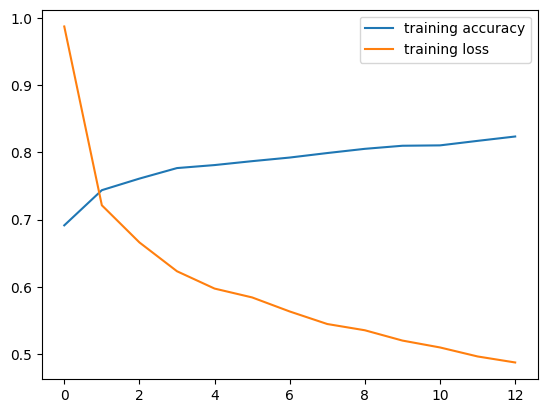

In [37]:
fig = plt.figure(num=1)
fig1 = fig.add_subplot(1,1,1)
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.plot(total_loss_train, label = 'training loss')
plt.legend()
plt.show()

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

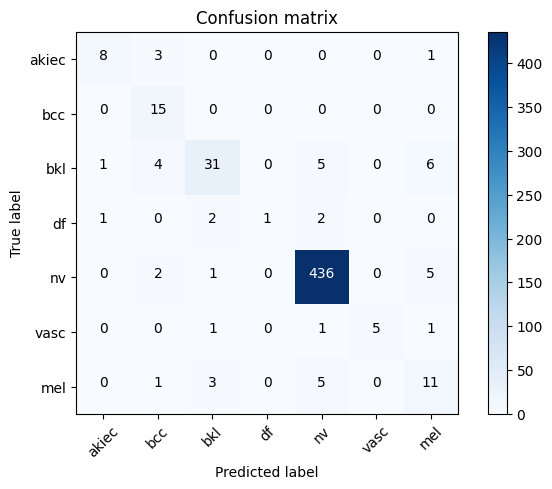

In [38]:
# Test data evaluation

model.eval()
test_y_label = []
test_y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        test_y_label.extend(labels.cpu().numpy())
        test_y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx_test = confusion_matrix(test_y_label, test_y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx_test, plot_labels)

In [39]:
# Generate a test classification report
report = classification_report(test_y_label, test_y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.80      0.67      0.73        12
         bcc       0.60      1.00      0.75        15
         bkl       0.82      0.66      0.73        47
          df       1.00      0.17      0.29         6
          nv       0.97      0.98      0.98       444
        vasc       1.00      0.62      0.77         8
         mel       0.46      0.55      0.50        20

    accuracy                           0.92       552
   macro avg       0.81      0.66      0.68       552
weighted avg       0.93      0.92      0.92       552



In [40]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y_label, test_y_predict)
print(accuracy)

0.9184782608695652
